# The Product Pricer With Linear Regression

A simple model that estimates how much a product costs based on extracted numeric features, such as weight, brand, text length, and popularity rank — rather than raw text descriptions.

## Purpose

To demonstrate a baseline regression model that can predict prices from structured data.
This serves as the foundation to later compare and improve upon with more advanced models.

### Baseline Models

In [ ]:
!pip install pandas numpy scikit-learn gensim huggingface-hub

In [33]:
### General Imports
import os
import math
import json
import random
from dotenv import load_dotenv
import matplotlib.pyplot as plt 
import pickle 
from collections import Counter
from huggingface_hub import login

In [34]:
### Imports For Traditional Machine Learning

import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [35]:
### For NLP related machine learning

from sklearn.feature_extraction.text import CountVectorizer 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [36]:
### More of machine learning related ones
from sklearn.svm import LinearSVR 
from sklearn.ensemble import RandomForestRegressor 

In [37]:
### Internal Classes

from items import Item

In [38]:
### Constants -- used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"green": GREEN, "orange": YELLOW, "red": RED} 

In [39]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN_KEY = os.getenv("HF_TOKEN")

login(HF_TOKEN_KEY)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [40]:
%matplotlib inline

## Loading the pkl files

In [41]:
with open("train.pkl", "rb") as f:
    train = pickle.load(f)

with open("test.pkl", "rb") as f:
    test = pickle.load(f)

In [42]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sydney Rustic Mirror - Vanity Mirror, Bathroom Mirror, Farmhouse Decor, Wood Mirror, Large Mirror - 4 Sizes & 20 Colors - Red Oak
The Sydney low profile thin wood framed mirror will blend effortlessly in your current decor creating a simple yet sophisticated look. Our mirror features a reclaimed rustic styled wood finish, strong decorative lines with a thin 2.25” inch wide frame maximizing the visible mirror. This hanging mirror can be mounted horizontally or vertically. Available in 20 Colors - Shown in Red Oak. Not sure on color we do color samples please contact us for details. Available in 4 sizes, 24x30, 36x30, 42x30 & 60x30, all measurements are overall dimensions including frame and mirror. We offer two types

Price is $


In [43]:
print(test[0].price)

189.99


## Tester Class

In [44]:
class Tester: 

    def __init__(self, predictor, title=None, data=test, size=250): 
        self.predictor = predictor
        self.data = data
        ### Conditionally used for either the text report or chart's title
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []
        self.guesses = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth): 
        if error < 20 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4: 
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i): 
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) < 40 else datapoint.title[:40] + "..."
        self.truths.append(truth)
        self.guesses.append(guess)
        self.errors.append(error) 
        self.sles.append(sle) 
        self.colors.append(color) 
        print(f"{COLOR_MAP[color]}{i + 1}: Guess: ${guess:,.2f} | Truth: ${truth:,.2f} | Error: {error:,.2f} | SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title): 
        max_error = max(self.errors) 
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color="deepskyblue", lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val) 
        plt.title(title)
        plt.show()

    def report(self): 
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits / self.size * 100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size): 
            self.run_datapoint(i) 
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


In [45]:
### Simulator function

def random_pricer(item): 
    return random.randrange(1, 1000)

1: Guess: $655.00 | Truth: $189.99 | Error: 465.01 | SLE: 1.52 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $115.00 | Truth: $64.45 | Error: 50.55 | SLE: 0.33 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $26.00 | Truth: $128.99 | Error: 102.99 | SLE: 2.47 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $760.00 | Truth: $252.70 | Error: 507.30 | SLE: 1.21 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $282.00 | Truth: $16.99 | Error: 265.01 | SLE: 7.59 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $251.00 | Truth: $499.99 | Error: 248.99 | SLE: 0.47 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $229.00 | Truth: $363.36 | Error: 134.36 | SLE: 0.21 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $143.00 | Truth: $24.75 | Error: 118.25 | SLE: 2.96 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $755.00 | Truth: $65.20 | Error: 689.80 | SLE: 5.93 Item: Knitter's Pride Bamboo Knitting N

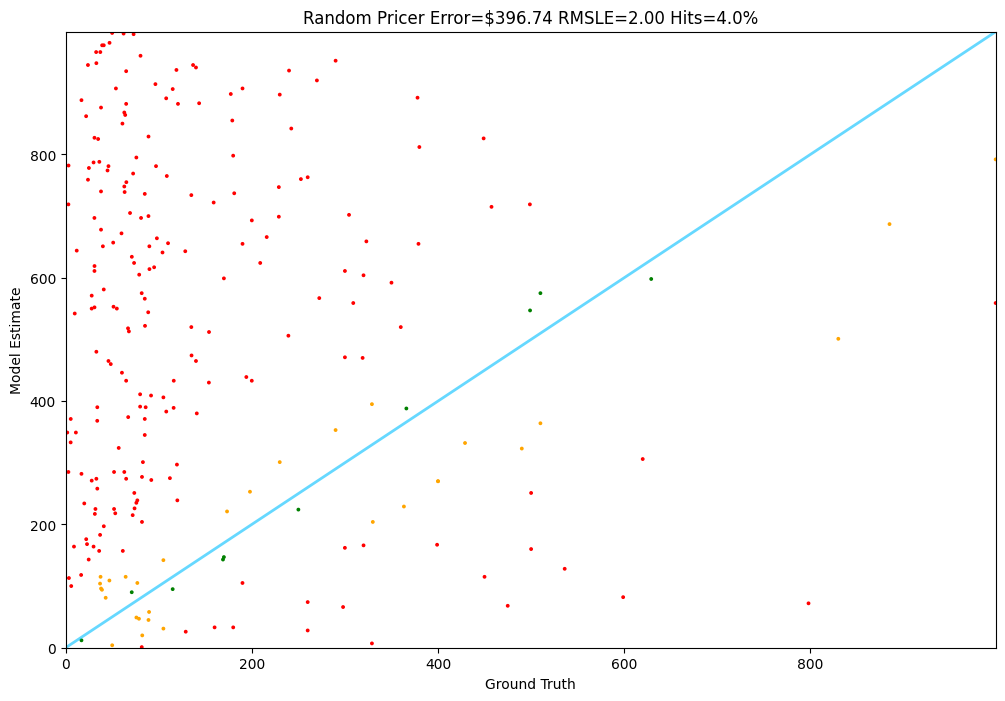

In [46]:
random.seed(42)

### Run Tester with a simulating guess predictor
Tester.test(random_pricer)

In [47]:
### Another test -- with average price from the train data

training_prices = [item.price for item in train]
training_avr_price = sum(training_prices) / len(training_prices)

def constant_pricer(item): 
    return training_avr_price 

1: Guess: $177.40 | Truth: $189.99 | Error: 12.59 | SLE: 0.00 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $177.40 | Truth: $64.45 | Error: 112.95 | SLE: 1.01 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $177.40 | Truth: $128.99 | Error: 48.41 | SLE: 0.10 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $177.40 | Truth: $252.70 | Error: 75.30 | SLE: 0.12 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $177.40 | Truth: $16.99 | Error: 160.41 | SLE: 5.26 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $177.40 | Truth: $499.99 | Error: 322.59 | SLE: 1.07 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $177.40 | Truth: $363.36 | Error: 185.96 | SLE: 0.51 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $177.40 | Truth: $24.75 | Error: 152.65 | SLE: 3.75 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $177.40 | Truth: $65.20 | Error: 112.20 | SLE: 0.98 Item: Knitter's Pride Bamboo Knitting Ne

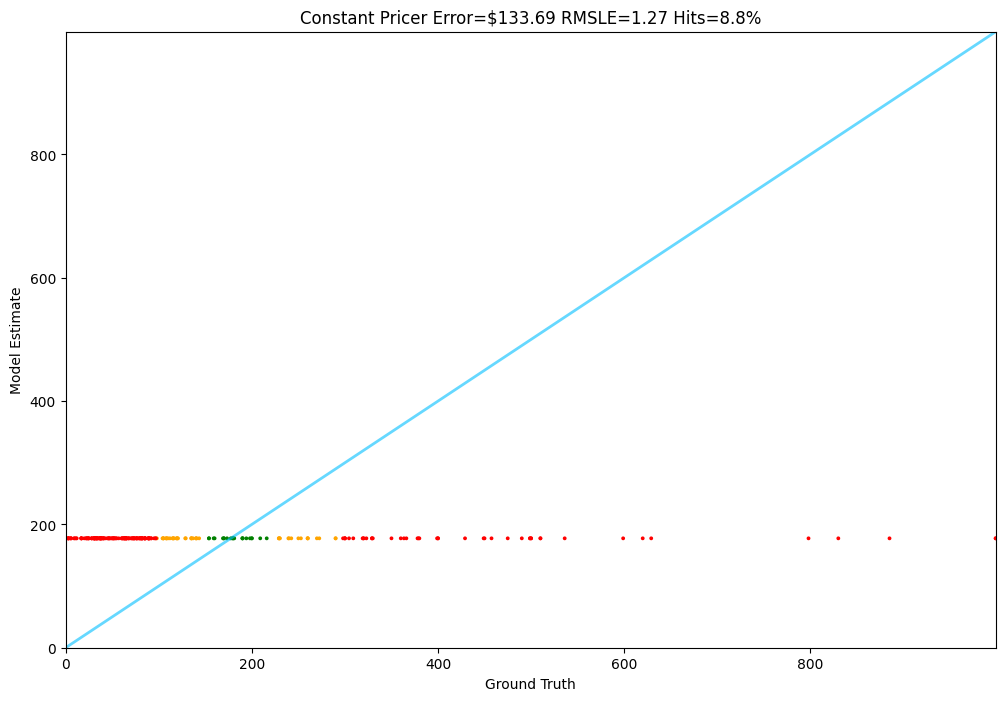

In [48]:
Tester.test(constant_pricer)

## Feature Engineering Mockup Practice

Educational example using product weights, brand, and other fields 
to demonstrate feature engineering, not meant for real world usage.

In [49]:
train[0].details

'{"Package Dimensions": "12.4 x 10.08 x 7.76 inches", "Item Weight": "5.33 pounds", "Item model number": "MS300", "Best Sellers Rank": {"Photographic Lighting Monolights": 296}, "Date First Available": "August 4, 2019", "Manufacturer": "Godox", "Brand": "GODOX", "Compatible Mountings": "Nikon", "Camera Flash": "Studio", "Included Components": "MS Flash Head *1 Power Cord *1 Lamp Cover *1", "Wireless Communication Technology": "Optical Pulse"}'

In [50]:
### Create a new "features" field on items, 
### and populate it with json parsed from the details dict

for item in train: 
    item.features = json.loads(item.details)

for item in test: 
    item.features = json.loads(item.details)

In [51]:
print(train[0].features.keys())

dict_keys(['Package Dimensions', 'Item Weight', 'Item model number', 'Best Sellers Rank', 'Date First Available', 'Manufacturer', 'Brand', 'Compatible Mountings', 'Camera Flash', 'Included Components', 'Wireless Communication Technology'])


In [52]:
### Look at 20 most common features in training set

feature_count = Counter()

for item in train: 
    for f in item.features.keys(): 
        feature_count[f] += 1

feature_count.most_common(20)

[('Item Weight', 180480),
 ('Date First Available', 176260),
 ('Manufacturer', 172893),
 ('Best Sellers Rank', 157663),
 ('Item model number', 156533),
 ('Brand', 149365),
 ('Product Dimensions', 143132),
 ('Is Discontinued By Manufacturer', 99915),
 ('Color', 84712),
 ('Material', 56543),
 ('Country of Origin', 52131),
 ('Package Dimensions', 52033),
 ('Manufacturer recommended age', 42495),
 ('Item Dimensions LxWxH', 35079),
 ('Special Feature', 32950),
 ('Model Name', 28393),
 ('Connectivity Technology', 25923),
 ('Batteries', 24674),
 ('Compatible Devices', 23240),
 ('Item Dimensions  LxWxH', 20308)]

### Product Weights

In [53]:
# Some janky code to pluck out the Item Weight

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [54]:
weights = [get_weight(t) for t in test]

### Filter out None values (if w)
weights = [w for w in weights if w]

In [55]:
average_weight = sum(weights) / len(weights)
print(f"Avr Weight: {average_weight:.2f}")

Avr Weight: 5.71


In [56]:
### Set default weight for items with None value for weights
def get_defualt_weight(item): 
    weight = get_weight(item)
    return weight or average_weight

In [57]:
w = get_weight(train[1000])
print(w)

1.38


### Best Seller Ranks 

In [58]:
def get_rank(item): 
    """
    Get an average rank per item out of multiple ranks across different categories.
    """
    ### A product has ranks across multiple categories in Amazon data
    ranks_dict = item.features.get("Best Sellers Rank")
    if ranks_dict:
        ranks = ranks_dict.values()
        avr_rank = sum(ranks) / len(ranks)
        return avr_rank
        
    return None
    
    

In [59]:
get_rank(train[100])

323746.0

In [60]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]

average_rank = sum(ranks) / len(ranks)
print(f"Average Rank = {average_rank:,.2f}")

Average Rank = 123,129.66


In [61]:
def get_default_rank(item): 
    rank = get_rank(item)
    return rank or average_rank

In [62]:
def get_text_length(item): 
    return len(item.prompt)

In [63]:
### Look at 40 most common brands

brand_counts = Counter()

for t in train: 
    brand = t.features.get("Brand")
    if brand: 
        brand_counts[brand] += 1 

print(brand_counts.most_common(40))

[('HP', 4484), ('Dell', 3189), ('Lenovo', 2401), ('SAMSUNG', 1795), ('ASUS', 1377), ('Sony', 1309), ('Funko', 831), ('Canon', 815), ('Apple', 784), ('Intel', 669), ('Magic The Gathering', 637), ('Generic', 604), ('Nikon', 534), ('Garmin', 483), ('Pyle', 482), ('Panasonic', 448), ('MSI', 435), ('LG', 434), ('Rockville', 427), ('GODOX', 423), ('Microsoft', 414), ('Acer', 364), ('Fender', 336), ('AmScope', 317), ('Pokemon', 316), ('KICKER', 316), ('Yu-Gi-Oh!', 306), ('Logitech', 294), ('Gigabyte', 280), ('Harmony Audio', 277), ('Audio-Technica', 263), ('Fujifilm', 261), ('Western Digital', 248), ('Plantronics', 244), ('Ibanez', 243), ('acer', 241), ('Olympus', 235), ('DJI', 231), ('Bose', 229), ('Seagate', 229)]


In [64]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]

def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

print(is_top_electronics_brand(train[2300]))

True


### Result: get_features()

In [65]:
def get_features(item): 
    """
    Return weight, rank, text_length, and whether it's one of top electronics brands in a dictionary form
    """
    return {
        "weight": get_defualt_weight(item), 
        "rank": get_default_rank(item), 
        "text_length": get_text_length(item), 
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0 
    }

In [66]:
get_features(train[0])

{'weight': 5.33,
 'rank': 296.0,
 'text_length': 723,
 'is_top_electronics_brand': 0}

## Traditional Linear Regression

In [82]:
print(train[0].price)

109.0


In [88]:
# A utility function to convert the features(dict) into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    ### Add price label
    df["price"] = [item.price for item in items]

    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

240 Tons


In [89]:
print(train_df[:10])

      weight           rank  text_length  is_top_electronics_brand   price
0   5.330000     296.000000          723                         0  109.00
1   0.362500   11823.250000          549                         0   87.95
2   0.020000  386512.000000          706                         0    7.49
3   1.000000  314432.000000          665                         0   25.99
4   0.787500  141286.000000          575                         0   44.99
5   0.550000  752143.500000          594                         0   83.75
6   5.714881  123129.660484          812                         0  379.99
7   1.000000   24444.500000          818                         0   76.56
8  15.900000     188.000000          750                         0   90.98
9   0.130000  226782.000000          837                         0    8.88


In [98]:
### Traditional Linear Regression

np.random.seed(42)

### Separate features and target 
feature_columns = ["weight", "rank", "text_length", "is_top_electronics_brand"]

X_train = train_df[feature_columns]
y_train = train_df["price"]

X_test = test_df[feature_columns]
y_test = test_df["price"]

### Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

print(model.coef_)

### Print pairs of feature_columns and coefficients 
print("\n|==Metrics Report==|\n")
for features, coef in zip(feature_columns, model.coef_): 
    print(f"{features}: {coef}")

### Intercept rate
print(f"Intercept: {model.intercept_}")




[ 9.64013373e-01 -1.21243045e-04 -1.85446479e-02  2.22721213e+02]

|==Metrics Report==|

weight: 0.964013372775741
rank: -0.00012124304524521762
text_length: -0.018544647929444123
is_top_electronics_brand: 222.72121295691014
Intercept: 183.96637572726362
